In [55]:

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import binomtest as binom_test

from datetime import datetime, timedelta
from pathlib import Path
from scipy.stats import t
import os
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


Getting all the required data 

In [46]:
# getting the data from ELia's dataset 
# paths 

Root_dir = ".."
Data_dir = os.path.join(Root_dir, "data_extraction", "raw_df")

# load the CSV + computing the log returns
def load_with_log_returns(csv_filename,lag = 1):
	"""
	Load a CSV from the Data_dir and compute log returns and also the Log Prices  on the 'Close' column.
	This function is robust: it will handle CSVs that have either 'Date' or 'Datetime' (or both).
	It raises a clear error if neither date column or the 'Close' column is present.
	"""
	path = os.path.join(Data_dir, csv_filename)
	# Read first without forcing parse_dates so we can detect which date columns exist
	df = pd.read_csv(path)
	# Parse available date columns robustly
	for col in ['Date', 'Datetime']:
		if col in df.columns:
			df[col] = pd.to_datetime(df[col], errors='coerce')
	# Prefer 'Date' as the index, otherwise use 'Datetime' if present
	if 'Date' in df.columns and not df['Date'].isna().all():
		df.set_index('Date', inplace=True)
	elif 'Datetime' in df.columns and not df['Datetime'].isna().all():
		df.set_index('Datetime', inplace=True)
	else:
		raise ValueError(f"CSV {path} must contain a 'Date' or 'Datetime' column. Found: {list(df.columns)}")
	# Ensure 'Close' exists
	if 'Close' not in df.columns:
		raise ValueError(f"CSV {path} must contain a 'Close' column. Found: {list(df.columns)}")
	# Compute log returns safely (first entry will be NaN)
	df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(lag))
	
	df['Log_Prices'] = np.log(df['Close'])
	return df


nasdaq_daily_df = load_with_log_returns('nasdaq_daily_df.csv')
nasdaq_weekly_df = load_with_log_returns('nasdaq_weekly_df.csv')
nasdaq_monthly_df = load_with_log_returns('nasdaq_monthly_df.csv')
nasdaq_hourly_df = load_with_log_returns('nasdaq_hourly_df.csv')

# The DataFrame uses 'Date' (or 'Datetime') as the index, so select the 'Log_Returns' column directly.
nasdaq_daily_log_returns = nasdaq_daily_df['Log_Returns'].dropna()
nasdaq_weekly_log_returns = nasdaq_weekly_df['Log_Returns'].dropna()
nasdaq_monthly_log_returns = nasdaq_monthly_df['Log_Returns'].dropna()
nasdaq_hourly_df_log_returns = nasdaq_hourly_df['Log_Returns'].dropna()

nasdaq_hourly_df_log_prices = nasdaq_hourly_df['Log_Prices'].dropna()
nasdaq_daily_df_log_prices = nasdaq_daily_df['Log_Prices'].dropna()
nasdaq_weekly_df_log_prices = nasdaq_weekly_df['Log_Prices'].dropna()
nasdaq_monthly_df_log_prices = nasdaq_monthly_df['Log_Prices'].dropna()


Section 1 - Log prices time series plots

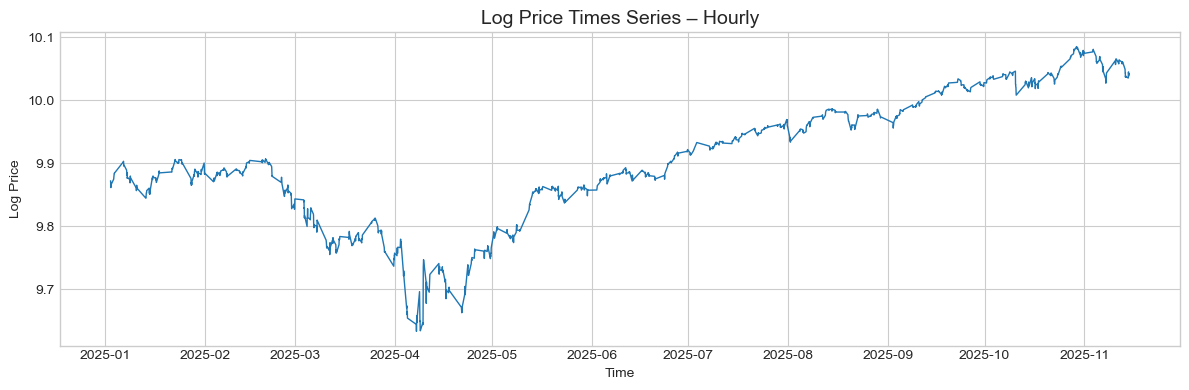

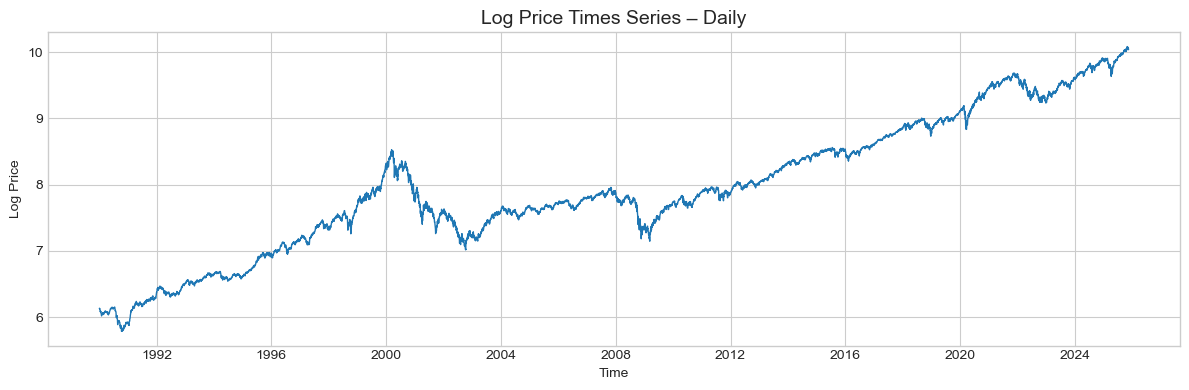

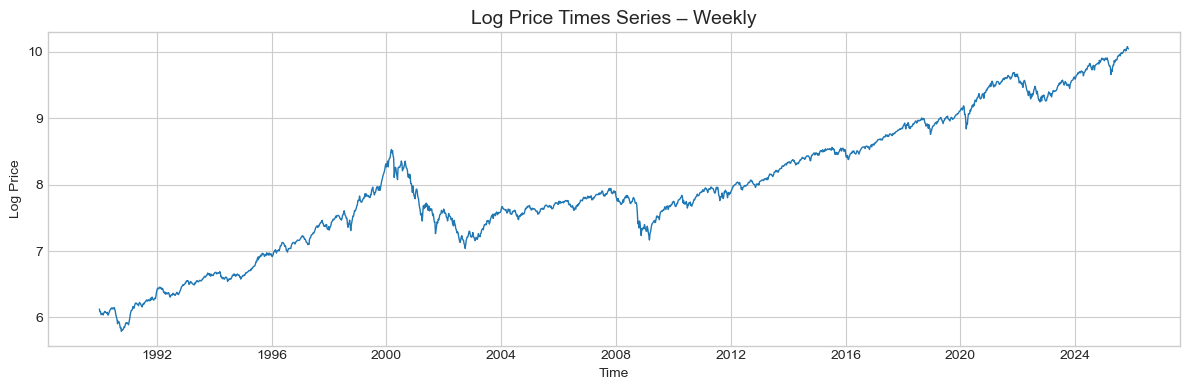

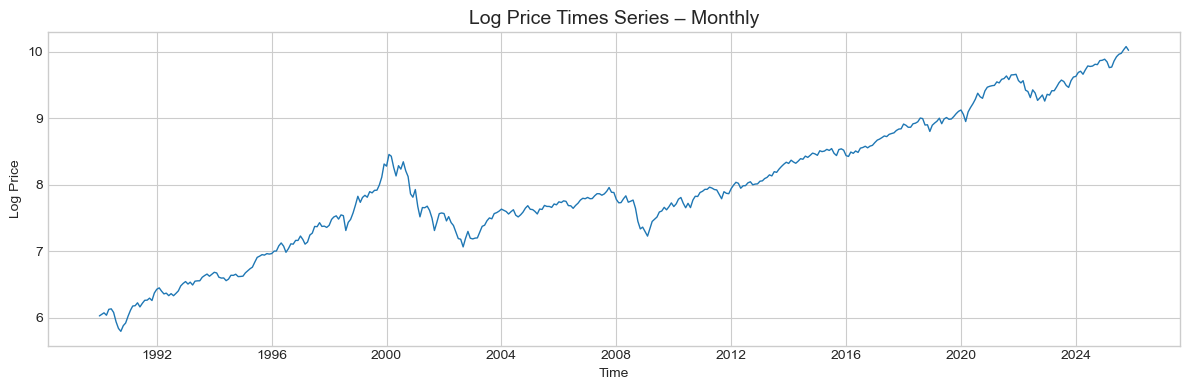

In [47]:
def plot_log_prices(series, title):
    plt.figure(figsize=(12,4))
    plt.plot(series.index, series.values, linewidth=1)
    plt.title(f"Log Price Times Series – {title}", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel("Log Price")
    plt.tight_layout()
    plt.show()

plot_log_prices(nasdaq_hourly_df_log_prices,  "Hourly")
plot_log_prices(nasdaq_daily_df_log_prices,   "Daily")
plot_log_prices(nasdaq_weekly_df_log_prices,  "Weekly")
plot_log_prices(nasdaq_monthly_df_log_prices, "Monthly")


Log Returns - Prices 1st Difference PLot --> WN plot

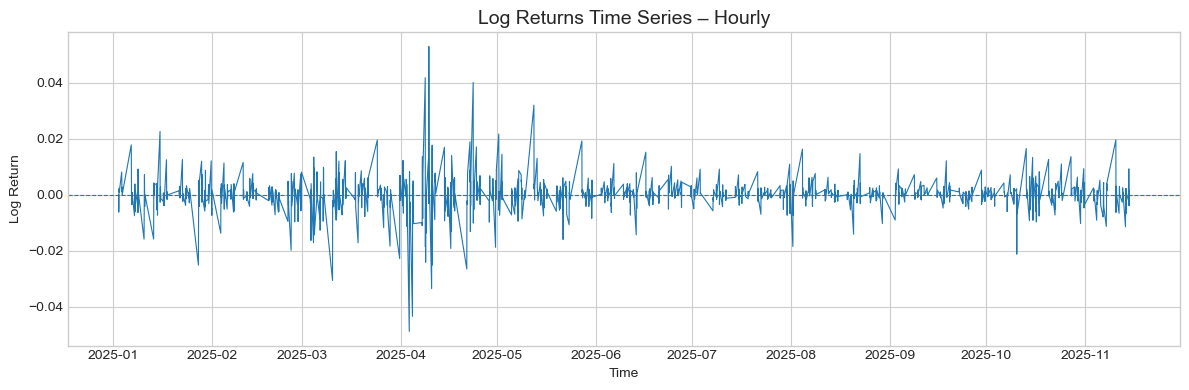

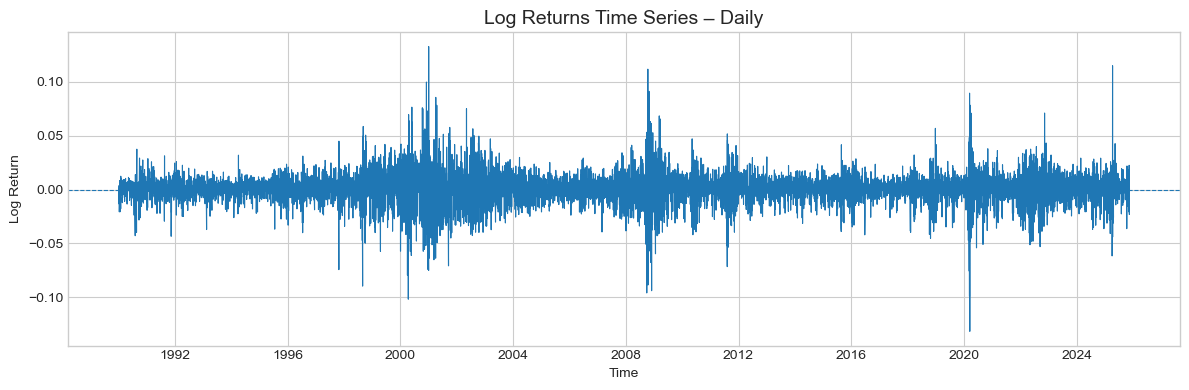

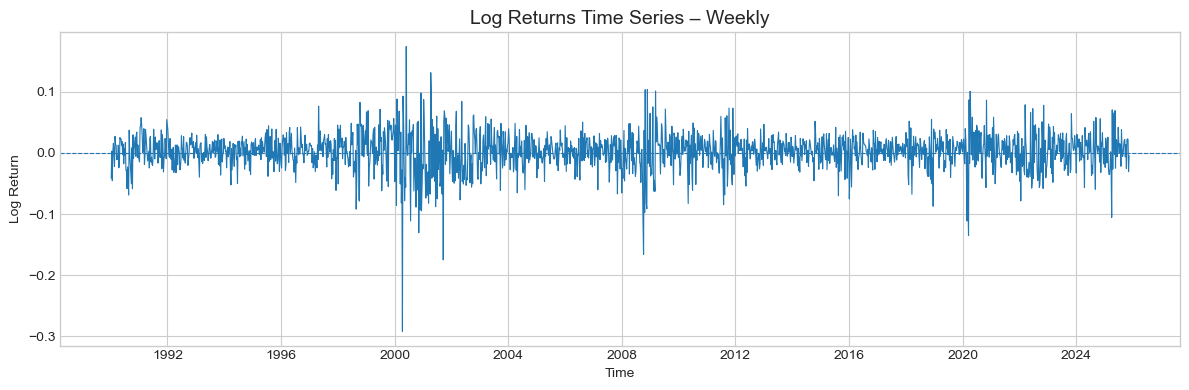

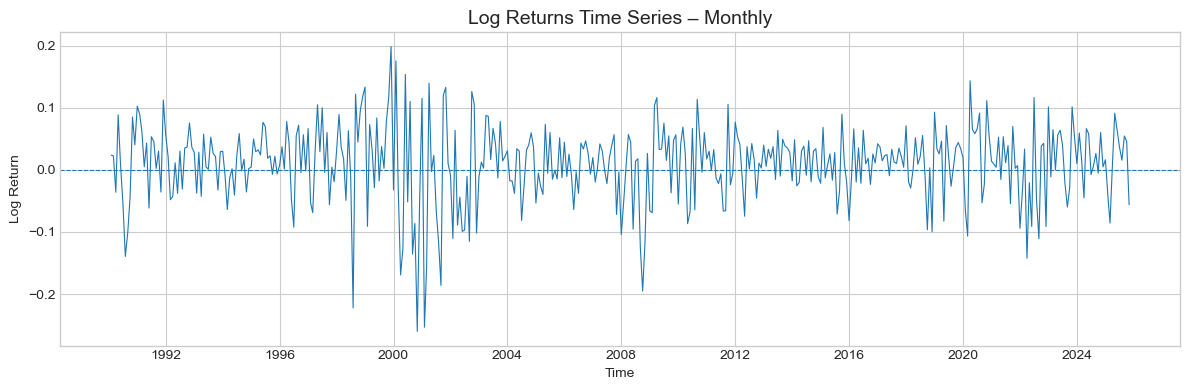

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_log_returns(obj, title, col=None):
    """
    obj : pd.Series or pd.DataFrame
        - If Series: it is assumed to be the log-returns.
        - If DataFrame: you must either pass col, or it must have exactly 1 column.
    col : str or None
        Column name if obj is a DataFrame with multiple columns.
    """
    # --- Extract the Series y ---
    if isinstance(obj, pd.Series):
        y = obj
    elif isinstance(obj, pd.DataFrame):
        if col is not None:
            y = obj[col]
        else:
            # If no column given, try to use the only column
            if obj.shape[1] != 1:
                raise ValueError(
                    "DataFrame has multiple columns; please specify 'col='."
                )
            y = obj.iloc[:, 0]
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")

    # --- Plot ---
    plt.figure(figsize=(12, 4))
    plt.plot(y.index, y.values, linewidth=0.8)
    plt.axhline(0, linestyle="--", linewidth=0.8)
    plt.title(f"Log Returns Time Series – {title}", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel("Log Return")
    plt.tight_layout()
    plt.show()

plot_log_returns(nasdaq_hourly_df_log_returns,  "Hourly")
plot_log_returns(nasdaq_daily_log_returns,   "Daily")
plot_log_returns(nasdaq_weekly_log_returns,  "Weekly")
plot_log_returns(nasdaq_monthly_log_returns, "Monthly")



Histogram of Returns + Normal PDF Overlay

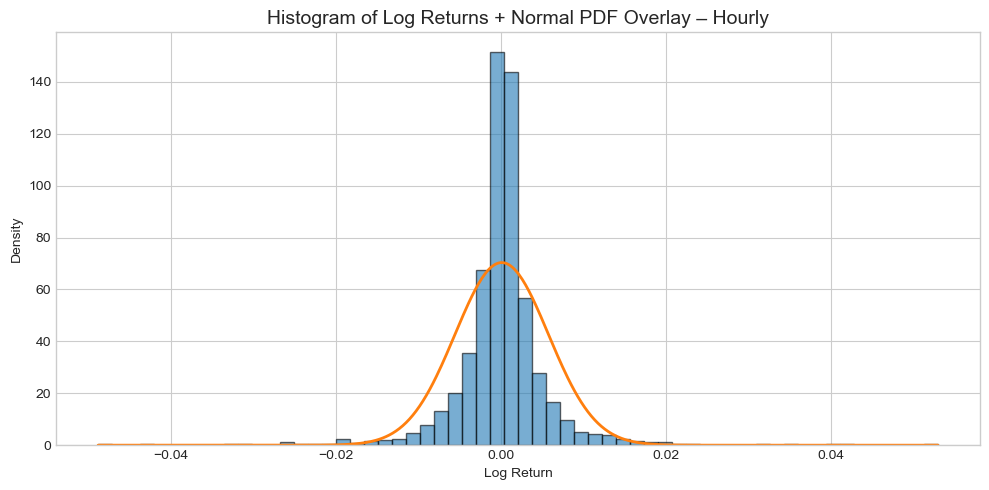

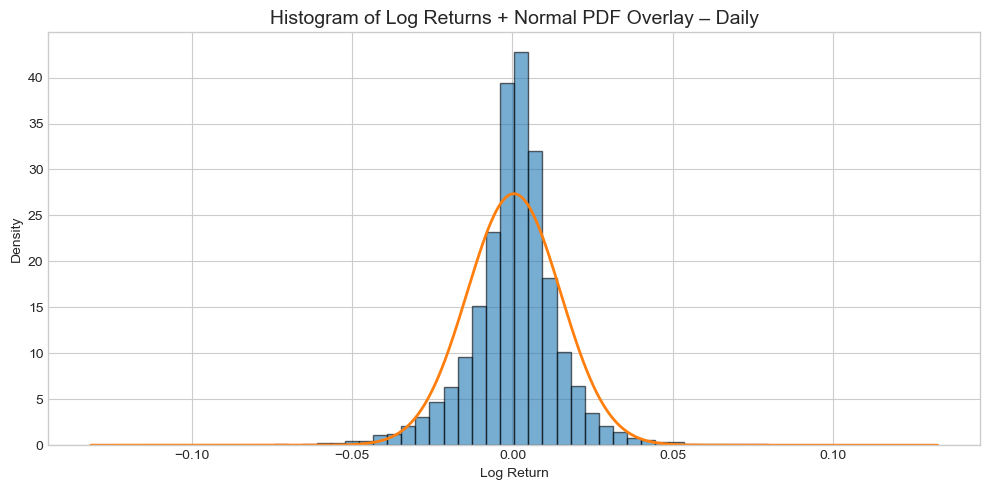

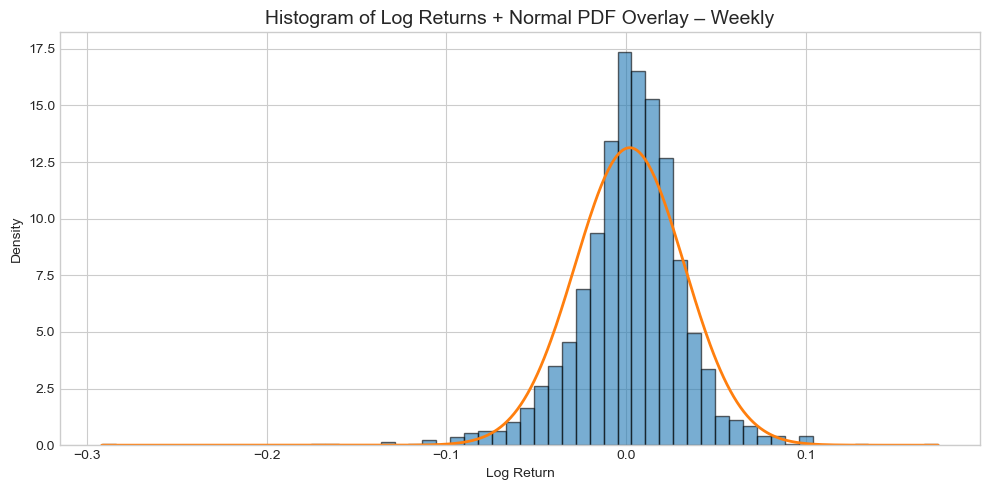

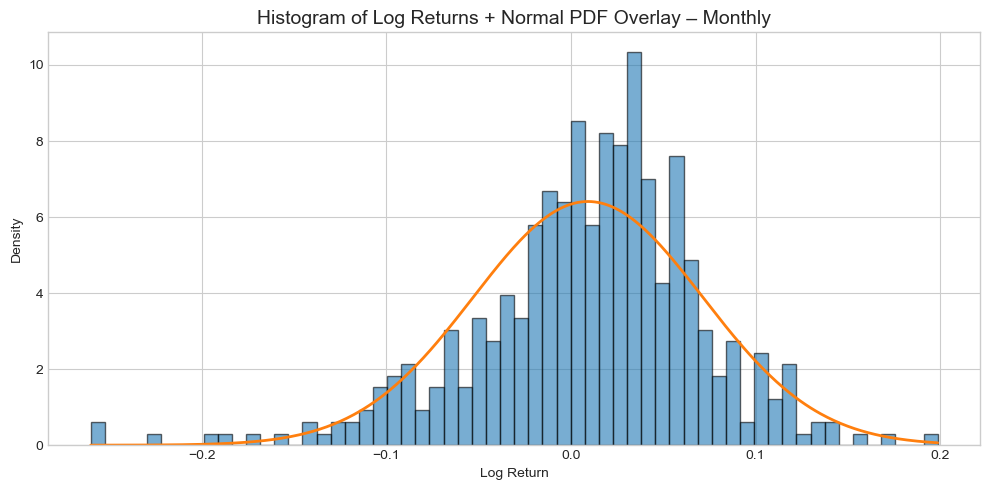

In [49]:
# Histogram of Returns + Normal PDF Overlay
def plot_return_histogram(obj, title, col=None, bins=60):
    """
    obj : Series or DataFrame of returns
    col : column name if obj is a DataFrame with multiple columns
    """
    # --- Extract the series ---
    if isinstance(obj, pd.Series):
        r = obj.dropna()
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns. Provide col='colname'.")
            r = obj.iloc[:, 0].dropna()
        else:
            r = obj[col].dropna()
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")

    # --- Fit normal distribution ---
    mu, sigma = r.mean(), r.std()

    # --- Plot ---
    plt.figure(figsize=(10, 5))
    
    # Histogram (density)
    plt.hist(r, bins=bins, density=True, alpha=0.6, edgecolor="black")

    # Normal PDF overlay
    x_vals = np.linspace(r.min(), r.max(), 500)
    pdf_vals = norm.pdf(x_vals, mu, sigma)
    plt.plot(x_vals, pdf_vals, linewidth=2)

    # Title & labels
    plt.title(f"Histogram of Log Returns + Normal PDF Overlay – {title}", fontsize=14)
    plt.xlabel("Log Return")
    plt.ylabel("Density")
    
    plt.tight_layout()
    plt.show()
    
plot_return_histogram(nasdaq_hourly_df_log_returns,  "Hourly",  col="Log_Returns")
plot_return_histogram(nasdaq_daily_log_returns,   "Daily",   col="Log_Returns")
plot_return_histogram(nasdaq_weekly_log_returns,  "Weekly",  col="Log_Returns")
plot_return_histogram(nasdaq_monthly_log_returns, "Monthly", col="Log_Returns")



QQ Plot Returns

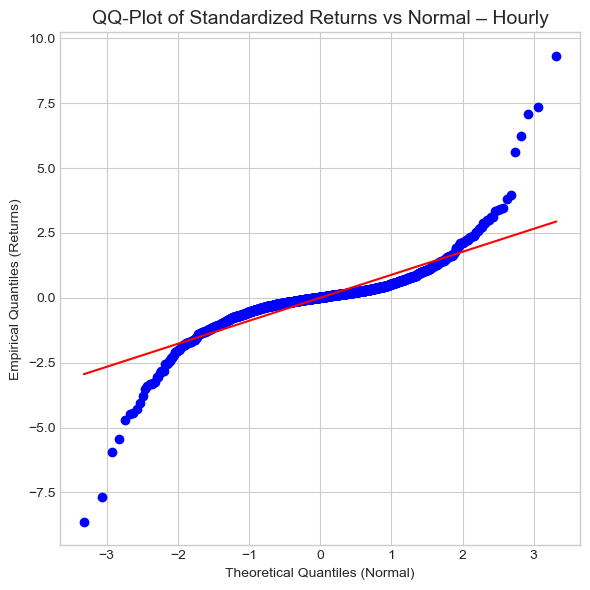

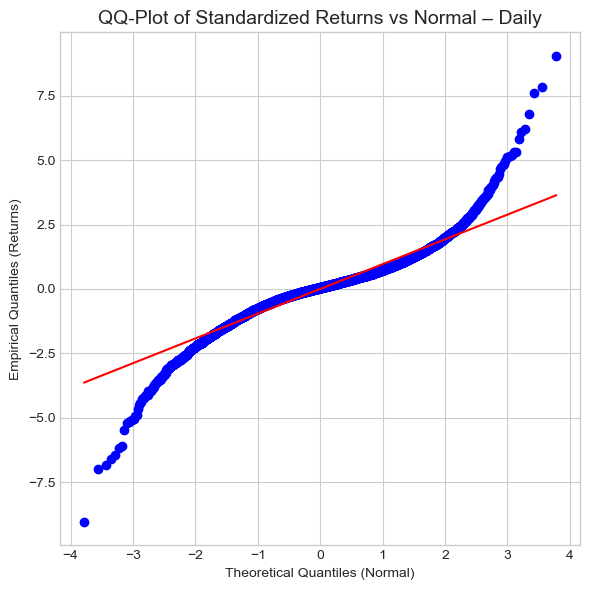

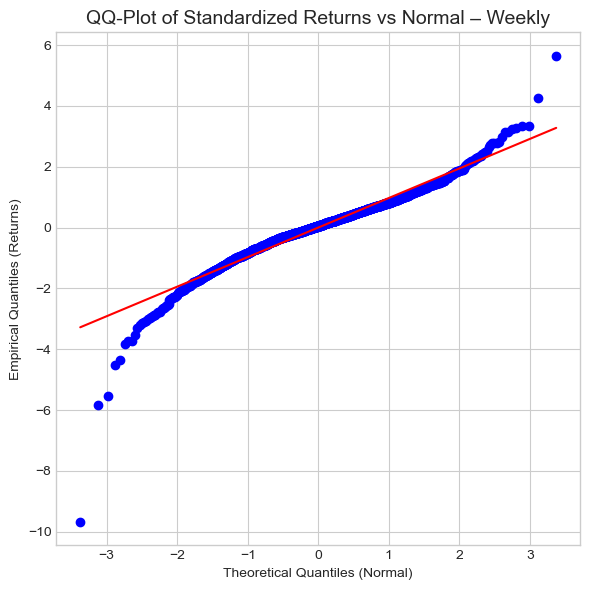

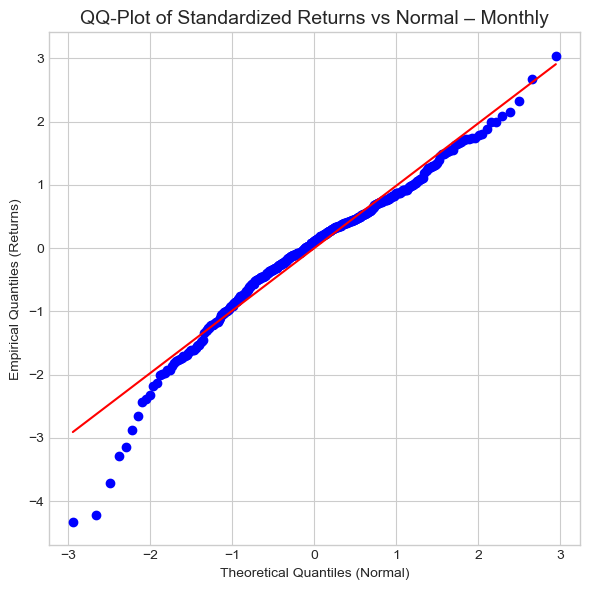

In [50]:
def plot_return_qq(obj, title, col=None):
    """
    QQ-plot of returns vs Normal(μ, σ).
    
    obj : pd.Series or pd.DataFrame
        - If Series: taken as the returns.
        - If DataFrame: use 'col' or the only column.
    col : str or None
        Column name if obj is a DataFrame with multiple columns.
    """
    # --- Extract the series ---
    if isinstance(obj, pd.Series):
        r = obj.dropna()
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns; please specify col='colname'.")
            r = obj.iloc[:, 0].dropna()
        else:
            r = obj[col].dropna()
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")
    
    # Standardize returns to compare shape (tails) only
    r_std = (r - r.mean()) / r.std()

    # --- QQ-plot ---
    plt.figure(figsize=(6, 6))
    # stats.probplot returns theoretical quantiles + ordered values; plot param draws it
    stats.probplot(r_std, dist="norm", plot=plt)
    plt.title(f"QQ-Plot of Standardized Returns vs Normal – {title}", fontsize=14)
    plt.xlabel("Theoretical Quantiles (Normal)")
    plt.ylabel("Empirical Quantiles (Returns)")
    plt.tight_layout()
    plt.show()
    
plot_return_qq(nasdaq_hourly_df_log_returns,  "Hourly",  col="Log_Returns")
plot_return_qq(nasdaq_daily_log_returns,   "Daily",   col="Log_Returns")
plot_return_qq(nasdaq_weekly_log_returns,  "Weekly",  col="Log_Returns")
plot_return_qq(nasdaq_monthly_log_returns, "Monthly", col="Log_Returns")

Mean Return with 95% CI Plot (Bar Plot)

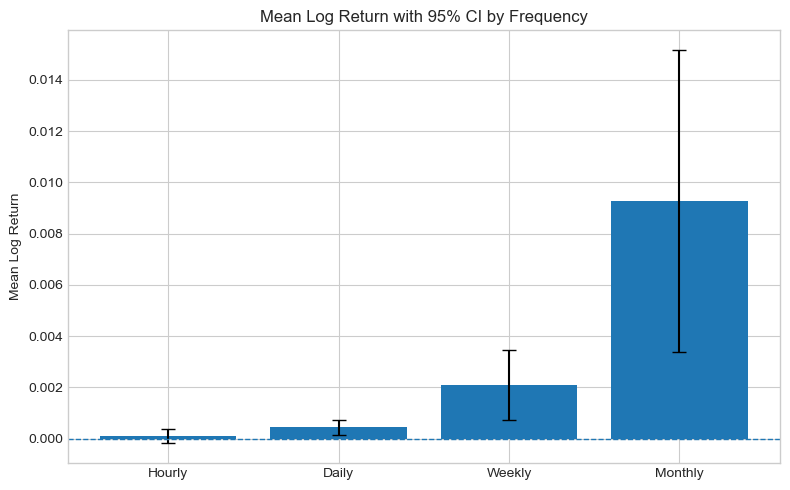

In [51]:
def extract_series(obj, col=None):
    """
    Helper: take a Series or DataFrame and return a 1D Series of returns.
    """
    if isinstance(obj, pd.Series):
        return obj.dropna()
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns, specify col='colname'.")
            return obj.iloc[:, 0].dropna()
        else:
            return obj[col].dropna()
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")

def mean_and_ci_95(series):
    """
    Return sample mean and symmetric 95% CI half-width using normal approximation.
    """
    series = series.dropna()
    n = len(series)
    mu = series.mean()
    sigma = series.std(ddof=1)
    se = sigma / np.sqrt(n)
    ci_half = 1.96 * se          # 95% CI half-width
    return mu, ci_half

# ---- Prepare your frequencies ----
# If your objects are DataFrames with a specific column, add col="Log_Returns" in extract_series
freq_data = {
    "Hourly":  extract_series(nasdaq_hourly_df_log_returns),
    "Daily":   extract_series(nasdaq_daily_log_returns),
    "Weekly":  extract_series(nasdaq_weekly_log_returns),
    "Monthly": extract_series(nasdaq_monthly_log_returns),
}

freqs = []
means = []
ci_halfs = []

for name, ser in freq_data.items():
    mu, ci_h = mean_and_ci_95(ser)
    freqs.append(name)
    means.append(mu)
    ci_halfs.append(ci_h)

# ---- Bar plot with 95% CI ----
x = np.arange(len(freqs))

plt.figure(figsize=(8, 5))
plt.bar(x, means, yerr=ci_halfs, capsize=5)
plt.axhline(0, linestyle="--", linewidth=1)

plt.xticks(x, freqs)
plt.ylabel("Mean Log Return")
plt.title("Mean Log Return with 95% CI by Frequency")

plt.tight_layout()
plt.show()



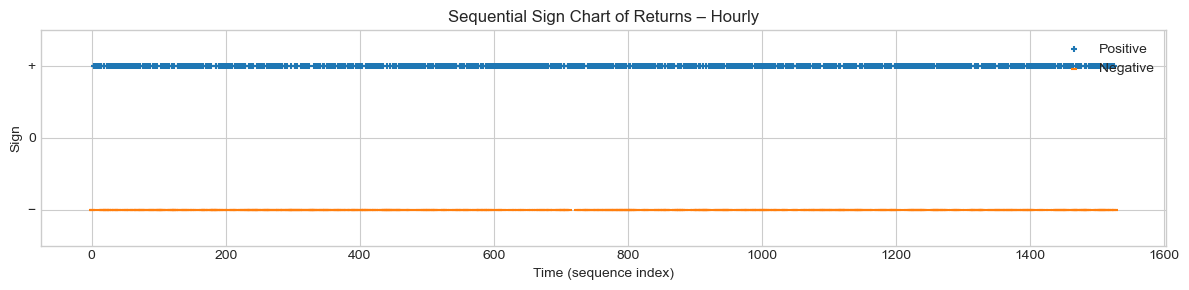

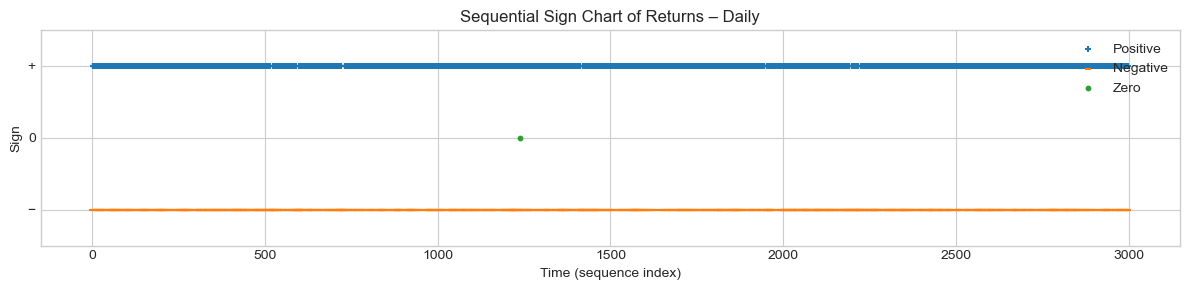

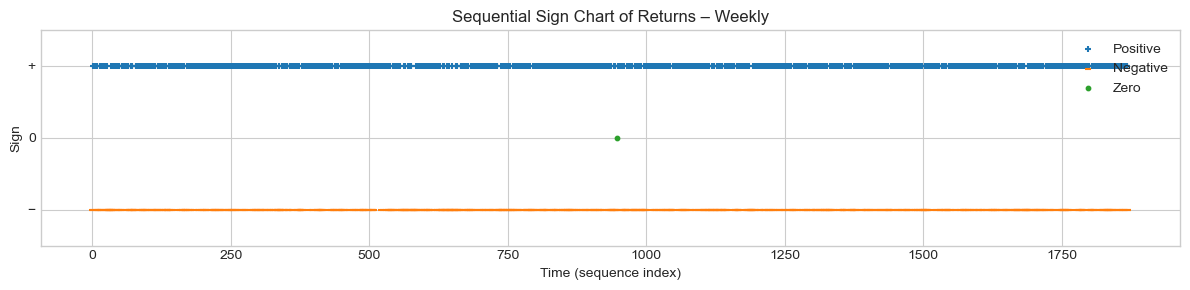

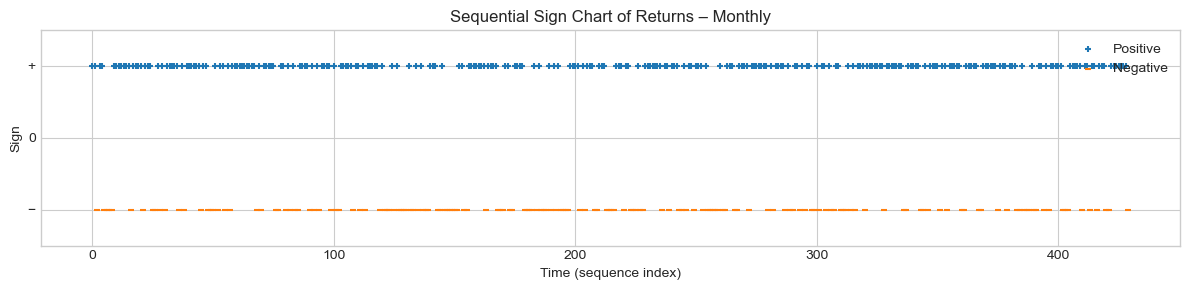

In [52]:
def extract_series(obj, col=None):
    """
    Helper: take a Series or DataFrame and return a 1D Series of returns.
    """
    if isinstance(obj, pd.Series):
        return obj.dropna()
    elif isinstance(obj, pd.DataFrame):
        if col is None:
            if obj.shape[1] != 1:
                raise ValueError("DataFrame has multiple columns, specify col='colname'.")
            return obj.iloc[:, 0].dropna()
        else:
            return obj[col].dropna()
    else:
        raise TypeError("obj must be a pandas Series or DataFrame")

def plot_sign_chart(obj, title, col=None, max_points=3000):
    """
    Sequential sign chart for Cowles–Jones type runs analysis.

    obj : Series or DataFrame of returns
    col : column name if obj is a DataFrame with multiple columns
    max_points : if series is very long, truncate to last max_points obs
    """
    r = extract_series(obj, col=col)

    # Optionally limit length (to keep plot readable)
    if len(r) > max_points:
        r = r.iloc[-max_points:]

    # Map returns to signs: +1, -1, 0
    sign = np.sign(r)
    # For clarity, keep three levels: -1 (negative), 0 (zero), +1 (positive)
    x = np.arange(len(sign))

    plt.figure(figsize=(12, 3))
    # Strip / dot plot
    plt.scatter(x[sign > 0], sign[sign > 0], marker="+", s=20, label="Positive")
    plt.scatter(x[sign < 0], sign[sign < 0], marker="_", s=20, label="Negative")
    if (sign == 0).any():
        plt.scatter(x[sign == 0], sign[sign == 0], marker="o", s=10, label="Zero")

    plt.yticks([-1, 0, 1], ["−", "0", "+"])
    plt.ylim(-1.5, 1.5)
    plt.xlabel("Time (sequence index)")
    plt.ylabel("Sign")
    plt.title(f"Sequential Sign Chart of Returns – {title}")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
    

plot_sign_chart(nasdaq_hourly_df_log_returns,  "Hourly",  col="Log_Returns")
plot_sign_chart(nasdaq_daily_log_returns,   "Daily",   col="Log_Returns")
plot_sign_chart(nasdaq_weekly_log_returns,  "Weekly",  col="Log_Returns")
plot_sign_chart(nasdaq_monthly_log_returns, "Monthly", col="Log_Returns")

RW2 - Autocorrelations structure of log prices 

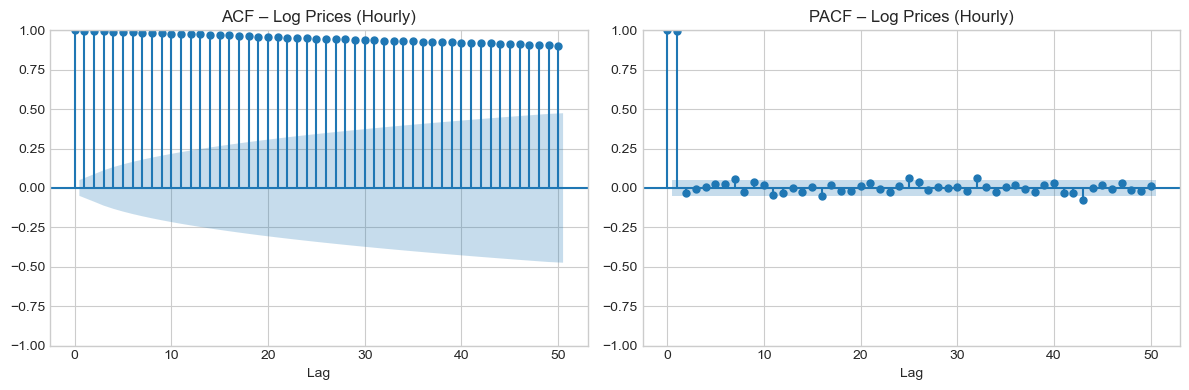

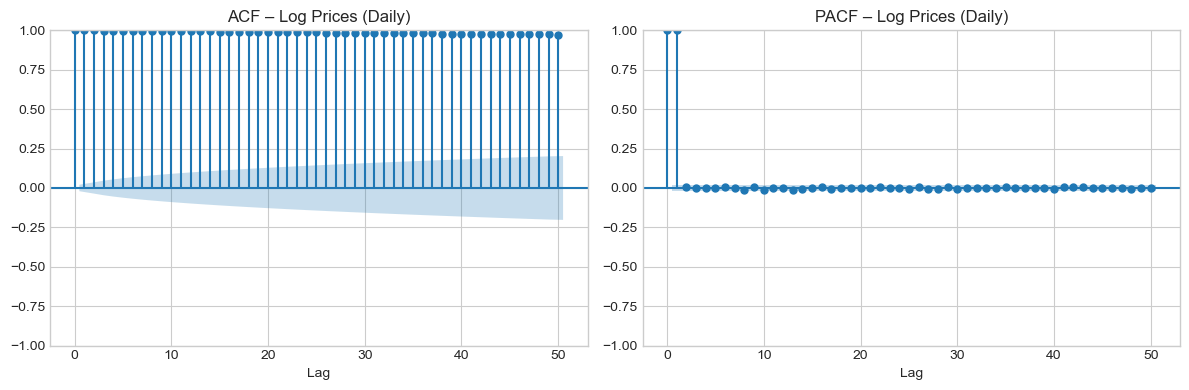

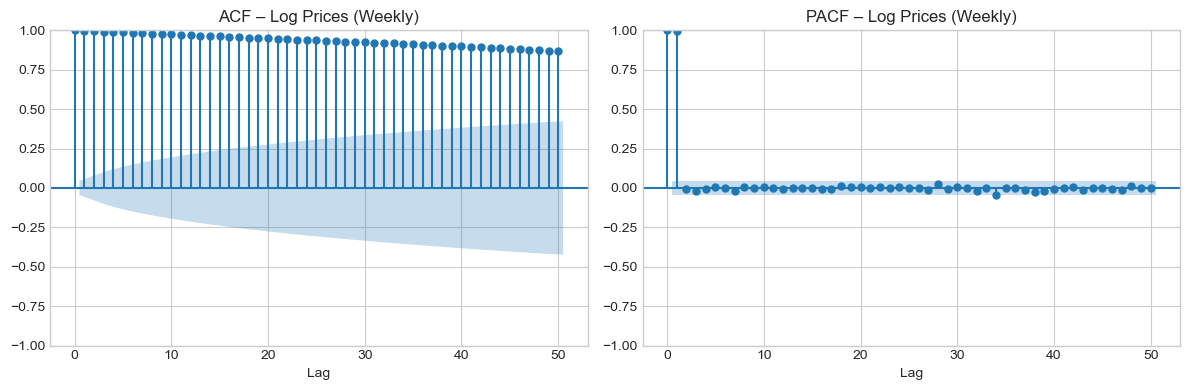

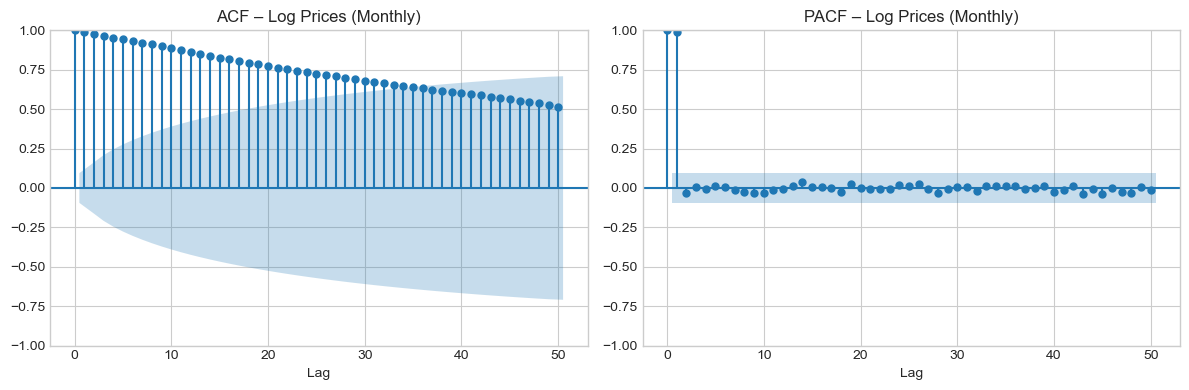

In [56]:
def plot_price_acf_pacf(obj, title, col=None, lags=50):
    """
    ACF and PACF of log prices to inspect persistence / unit-root behavior.

    obj  : Series or DataFrame containing log prices
    col  : optional column name if obj is a DataFrame
    lags : number of lags for ACF/PACF
    """
    y = extract_series(obj, col=col)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plot_acf(y, ax=axes[0], lags=lags)
    axes[0].set_title(f"ACF – Log Prices ({title})")

    plot_pacf(y, ax=axes[1], lags=lags, method="ywm")
    axes[1].set_title(f"PACF – Log Prices ({title})")

    for ax in axes:
        ax.set_xlabel("Lag")

    plt.tight_layout()
    plt.show()

plot_price_acf_pacf(nasdaq_hourly_df_log_prices,  "Hourly",  col="Log_Prices")
plot_price_acf_pacf(nasdaq_daily_df_log_prices,   "Daily",   col="Log_Prices")
plot_price_acf_pacf(nasdaq_weekly_df_log_prices,  "Weekly",  col="Log_Prices")
plot_price_acf_pacf(nasdaq_monthly_df_log_prices, "Monthly", col="Log_Prices")